# Implementing a convolutional neural network with images resized to 50.

## Two architectures are trained. All images are used.

### First architecture has poor performance, second one is good.

In [1]:
reset -fs

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import pickle
import gzip
import h5py
import dl_functions
from IPython.display import display
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### Loading data from a compressed pickle file that has 20,000 images pre-processed with a size of 50 by 50.

In [3]:
with gzip.open('pre_processed_images/image_data_20000_50.txt.gz', 'rb') as f:
    X, y = pickle.load(f)

#### Creating a train, test split.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### The labels need to be converted to categorical. Note that we have 2 categories: good (1) and bad (0) images.

In [5]:
y_train_sparse = np_utils.to_categorical(y_train, 2)

In [6]:
y_test_sparse = np_utils.to_categorical(y_test, 2)

#### Creating an instance of a CNN model.

##### The image size is 50.

In [7]:
IMG_SIZE = 50

In [8]:
model_1 = dl_functions.cnn_model_v_2(IMG_SIZE)

In [9]:
model_1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [10]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 19, 19, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 256)         295168    
__________

In [11]:
model_1.fit(X_train, y_train_sparse, batch_size=128, epochs=20, verbose=1, validation_split=0.3)

Train on 9800 samples, validate on 4200 samples
Epoch 1/20
9800/9800 [==============================] - 256s - loss: 7.8369 - acc: 0.5049 - val_loss: 8.1831 - val_acc: 0.4895
Epoch 2/20
9800/9800 [==============================] - 256s - loss: 7.9775 - acc: 0.5023 - val_loss: 8.1831 - val_acc: 0.4895
Epoch 3/20
9800/9800 [==============================] - 256s - loss: 7.9562 - acc: 0.5037 - val_loss: 8.1831 - val_acc: 0.4895
Epoch 4/20
9800/9800 [==============================] - 255s - loss: 7.9791 - acc: 0.5022 - val_loss: 8.1831 - val_acc: 0.4895
Epoch 5/20
9800/9800 [==============================] - 255s - loss: 7.9677 - acc: 0.5030 - val_loss: 8.1831 - val_acc: 0.4895
Epoch 6/20
9800/9800 [==============================] - 255s - loss: 7.9693 - acc: 0.5029 - val_loss: 8.1831 - val_acc: 0.4895
Epoch 7/20
9800/9800 [==============================] - 257s - loss: 7.9628 - acc: 0.5033 - val_loss: 8.1831 - val_acc: 0.4895
Epoch 8/20
9800/9800 [==============================] - 257s - 

In [12]:
score = model_1.evaluate(X_test, y_test_sparse, verbose=1)

6000/6000 [==============================] - 46s    


In [13]:
print('Test loss: {:0,.4f}'.format(score[0]))
print('Test accuracy: {:.2%}'.format(score[1]))

Test loss: 7.9697
Test accuracy: 50.28%


#### Saving model and weights.

In [14]:
model_1.save('models/model_v2_20000_50.h5')

In [15]:
model_1.save_weights('models/model_v2_20000_50_weights.h5')

#### Creating a list of predictions.

In [16]:
predicted_images = []
for i in model_1.predict(X_test):
    predicted_images.append(np.where(np.max(i) == i)[0])

#### Displaying a confusion matrix.

dl_functions.py:254: RuntimeWarning: invalid value encountered in divide
  'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),


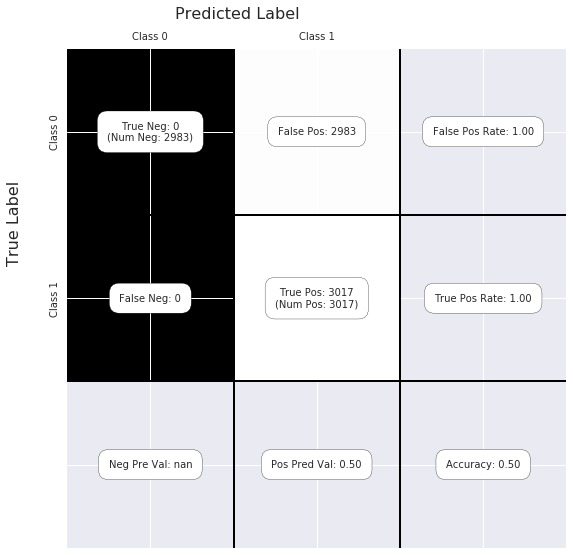

In [17]:
dl_functions.show_confusion_matrix(confusion_matrix(y_test, predicted_images), ['Class 0', 'Class 1'])

#### A more simple confusion matrix using pandas.

In [18]:
pd.DataFrame(confusion_matrix(y_test, predicted_images),columns = ['nok_image','ok_image'])

,nok_image,ok_image
0,0,2983
1,0,3017


#### Area Under the Curve.

In [20]:
print("AUC: {:.2%}\n".format(roc_auc_score(y_test, predicted_images)))

AUC: 50.00%



#### Getting predicted probabilities.

In [21]:
predictions_probability = model_1.predict_proba(X_test)

6000/6000 [==============================] - 45s    


#### Plotting a ROC curve.

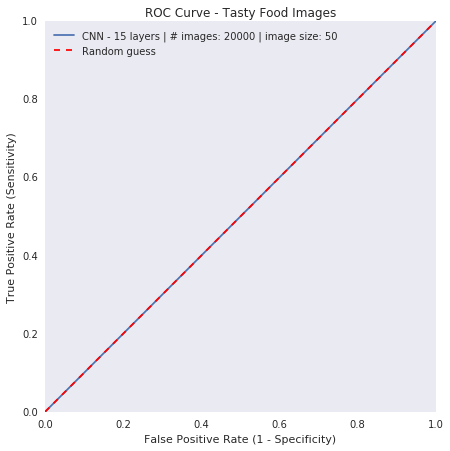

In [22]:
plt.figure(figsize=(7, 7))
dl_functions.plot_roc(y_test, predictions_probability[:,1], "CNN - " + str(len(model_1.layers)) + " layers | # images: " + str(len(X)) + " | image size: " + str(IMG_SIZE), "Tasty Food Images")

### Prediction using an image of Donald Trump.
<img src='images/trump_1.jpg' />

In [23]:
trump = dl_functions.normalize_images_array('images', IMG_SIZE)

In [24]:
trump_prediction = model_1.predict_classes(trump)

1/1 [==============================] - 0s


In [25]:
trump_prediction[0]

1

In [26]:
trump.shape

(1, 50, 50, 3)

In [27]:
trump = trump.reshape(trump.shape[1], trump.shape[2], trump.shape[3])

#### The model predicts the image as OK.

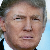

In [28]:
img = array_to_img(trump)
display(img)

### Using a different architecture. Proceeding same as above.

In [29]:
model_2 = dl_functions.cnn_model_v_1(IMG_SIZE)

In [30]:
model_2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [31]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
__________

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
y_train_sparse = np_utils.to_categorical(y_train, 2)

In [34]:
y_test_sparse = np_utils.to_categorical(y_test, 2)

In [35]:
model_2.fit(X_train, y_train_sparse, batch_size=128, epochs=50, verbose=1, validation_split=0.3)

Train on 9800 samples, validate on 4200 samples
Epoch 1/50
9800/9800 [==============================] - 22s - loss: 0.6380 - acc: 0.6366 - val_loss: 0.5744 - val_acc: 0.6738
Epoch 2/50
9800/9800 [==============================] - 22s - loss: 0.5503 - acc: 0.7268 - val_loss: 0.5251 - val_acc: 0.7414
Epoch 3/50
9800/9800 [==============================] - 23s - loss: 0.5206 - acc: 0.7499 - val_loss: 0.5021 - val_acc: 0.7524
Epoch 4/50
9800/9800 [==============================] - 23s - loss: 0.4856 - acc: 0.7735 - val_loss: 0.5044 - val_acc: 0.7495
Epoch 5/50
9800/9800 [==============================] - 24s - loss: 0.4681 - acc: 0.7837 - val_loss: 0.4319 - val_acc: 0.8017
Epoch 6/50
9800/9800 [==============================] - 24s - loss: 0.4514 - acc: 0.7940 - val_loss: 0.4446 - val_acc: 0.7910
Epoch 7/50
9800/9800 [==============================] - 24s - loss: 0.4344 - acc: 0.8048 - val_loss: 0.4530 - val_acc: 0.7893
Epoch 8/50
9800/9800 [==============================] - 24s - loss: 0.

In [36]:
score = model_2.evaluate(X_test, y_test_sparse, verbose=1)

5952/6000 [============================>.] - ETA: 0s

In [37]:
print('Test loss: {:0,.4f}'.format(score[0]))
print('Test accuracy: {:.2%}'.format(score[1]))

Test loss: 1.0730
Test accuracy: 79.48%


In [38]:
model_2.save('models/model_v1_20000_50.h5')

In [39]:
model_2.save_weights('models/model_v1_20000_50_weights.h5')

In [40]:
predicted_images = []
for i in model_2.predict(X_test):
    predicted_images.append(np.where(np.max(i) == i)[0])

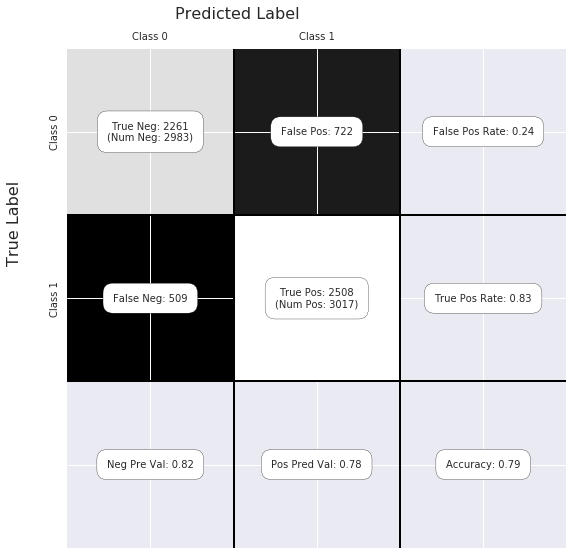

In [41]:
dl_functions.show_confusion_matrix(confusion_matrix(y_test, predicted_images), ['Class 0', 'Class 1'])

In [42]:
pd.DataFrame(confusion_matrix(y_test, predicted_images),columns = ['nok_image','ok_image'])

,nok_image,ok_image
0,2261,722
1,509,2508


In [43]:
print("AUC: {:.2%}\n".format(roc_auc_score(y_test, predicted_images)))

AUC: 79.46%



In [44]:
predictions_probability = model_2.predict_proba(X_test)

5952/6000 [============================>.] - ETA: 0s

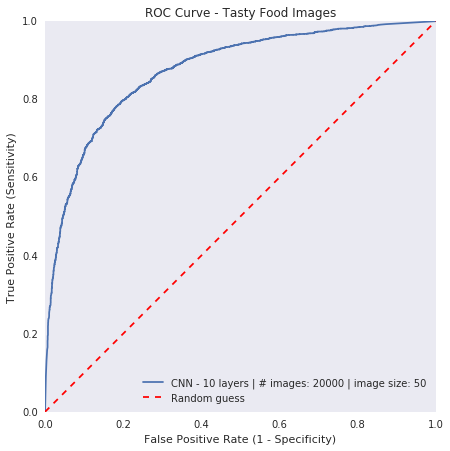

In [45]:
plt.figure(figsize=(7, 7))
dl_functions.plot_roc(y_test, predictions_probability[:,1], "CNN - " + str(len(model_2.layers)) + " layers | # images: " + str(len(X)) + " | image size: " + str(IMG_SIZE), "Tasty Food Images")

In [46]:
trump = dl_functions.normalize_images_array('images', IMG_SIZE)

In [47]:
trump_prediction = model_2.predict_classes(trump)

1/1 [==============================] - 0s


In [48]:
trump_prediction[0]

0

In [49]:
trump.shape

(1, 50, 50, 3)

In [50]:
trump = trump.reshape(trump.shape[1], trump.shape[2], trump.shape[3])

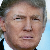

In [51]:
img = array_to_img(trump)
display(img)

#### Copying model and weights to a bucket.

In [52]:
!gsutil cp -r 'models' 'gs://wellio-kadaif-tasty-images-project-pre-processed-images'

Copying file://models/model_v2_20000_50.h5 [Content-Type=application/octet-stream]...
Copying file://models/model_v1_20000_50_weights.h5 [Content-Type=application/octet-stream]...
Copying file://models/model_v1_20000_50.h5 [Content-Type=application/octet-stream]...
Copying file://models/model_v2_20000_50_weights.h5 [Content-Type=application/octet-stream]...
|
Operation completed over 4 objects/22.6 MiB.                                     
